# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

import dataset_loader
from oxonfair import FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [ ]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,val_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [ ]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.867988,0.851609
Balanced Accuracy,0.793714,0.741194
F1 score,0.702473,0.630656
MCC,0.621491,0.557924
Precision,0.762420,0.779738
Recall,0.651266,0.529432
ROC AUC,0.921281,0.819372


In [ ]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Class Imbalance,0.194620,0.194620
Demographic Parity,0.196756,0.026867
Disparate Impact,0.270278,0.843233
Average Group Difference in Accuracy,0.095114,0.086356
Average Group Difference in Recall,0.154235,0.255881
Average Group Difference in Conditional Acceptance Rate,0.371545,1.017139
Average Group Difference in Acceptance Rate,0.019552,0.305805
Average Group Difference in Specificity,0.074883,0.038690
Average Group Difference in Conditional Rejectance Rate,0.007628,0.201110
Average Group Difference in Rejection Rate,0.078869,0.154382


In [ ]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.867988           0.793714  0.702473  0.621491   
         0                   0.931571           0.751168  0.624152  0.602724   
         1                   0.836457           0.790844  0.714805  0.602836   
         Maximum difference  0.095114           0.039676  0.090653  0.000112   
updated  Overall             0.851609           0.741194  0.630656  0.557924   
         0                   0.909338           0.837945  0.642648  0.599510   
         1                   0.822982           0.729350  0.627481  0.559800   
         Maximum difference  0.086356           0.108595  0.015167  0.039710   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.762420  0.651266  0.921281   
         0                    0.779661  0.520362  0.936936   
         1                    0.760109  0.674597  0.903690   
         Maximum difference   0.019552  0.154235  0.033246   
updated  Overall              0.779738  0.529432  0.819372   
         0                    0.564103  0.746606  0.936936   
         1                    0.869907  0.490726  0.903691   
         Maximum difference   0.305805  0.255881  0.033246   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12211.0          2922.0   
         0                                 4048.0           442.0   
         1                                 8163.0          2480.0   
         Maximum difference                4115.0          2038.0   
updated  Overall                          12211.0          2922.0   
         0                                 4048.0           442.0   
         1                                 8163.0          2480.0   
         Maximum difference                4115.0          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.204406  
         0                                   0.072875  
         1                                   0.269631  
         Maximum difference                  0.196756  
updated  Overall                             0.162476  
         0                                   0.144516  
         1                                   0.171383  
         Maximum difference                  0.026867

In [ ]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [ ]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [ ]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Class Imbalance,0.095615,0.095615
Demographic Parity,0.082430,0.032572
Disparate Impact,0.650210,0.852440
Average Group Difference in Accuracy,0.063281,0.038865
Average Group Difference in Recall,0.246562,0.194449
Average Group Difference in Conditional Acceptance Rate,0.217600,0.457739
Average Group Difference in Acceptance Rate,0.123046,0.186790
Average Group Difference in Specificity,0.035656,0.044595
Average Group Difference in Conditional Rejectance Rate,0.024401,0.119348
Average Group Difference in Rejection Rate,0.053576,0.071033


In [ ]:
fpredictor.evaluate_fairness()

,original,updated
Class Imbalance,0.098272,0.098272
Demographic Parity,0.090694,0.019558
Disparate Impact,0.524412,0.897495
Average Group Difference in Accuracy,0.047692,0.045537
Average Group Difference in Recall,0.141287,0.213380
Average Group Difference in Conditional Acceptance Rate,0.144147,0.493754
Average Group Difference in Acceptance Rate,0.119452,0.216872
Average Group Difference in Specificity,0.027360,0.028353
Average Group Difference in Conditional Rejectance Rate,0.014922,0.097745
Average Group Difference in Rejection Rate,0.040660,0.071143


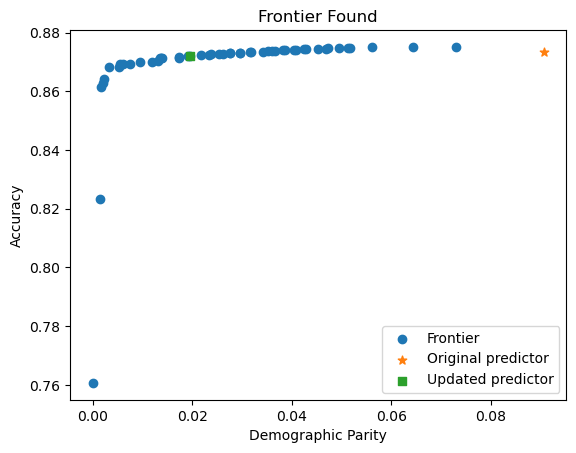

In [ ]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

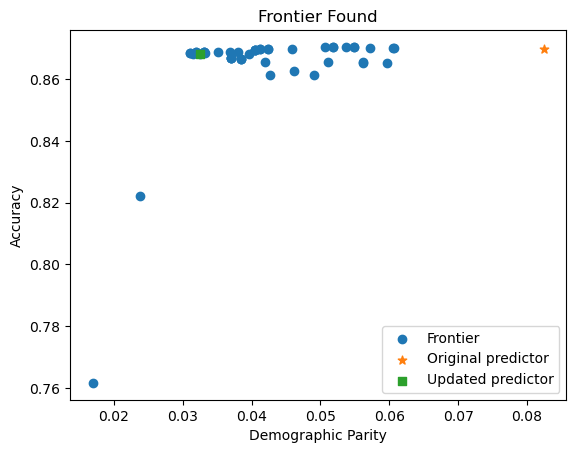

In [ ]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [ ]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.869708           0.797659  0.707805  0.627333   
         0                   0.877193           0.693240  0.500000  0.437430   
         1                   0.858757           0.811025  0.734043  0.639198   
         2                   0.921207           0.784086  0.671329  0.633859   
         3                   0.987952           0.993333  0.941176  0.936503   
         4                   0.863189           0.796505  0.709298  0.623157   
         Maximum difference  0.129195           0.300094  0.441176  0.499072   
updated  Overall             0.868234           0.785548  0.694861  0.617971   
         0                   0.850877           0.834821  0.604651  0.547110   
         1                   0.858757           0.782685  0.705882  0.628456   
         2                   0.899413           0.850122  0.677419  0.627055   
         3                   0.927711           0.960000  0.727273  0.725062   
         4                   0.864718           0.782205  0.696528  0.620214   
         Maximum difference  0.076834           0.177795  0.122622  0.177951   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.763773  0.659480  0.924173   
         0                    0.583333  0.437500  0.892219   
         1                    0.766667  0.704082  0.928253   
         2                    0.768000  0.596273  0.939164   
         3                    0.888889  1.000000  0.998333   
         4                    0.763883  0.661993  0.920837   
         Maximum difference   0.305556  0.562500  0.106114   
updated  Overall              0.779243  0.626968  0.902773   
         0                    0.481481  0.812500  0.892219   
         1                    0.833333  0.612245  0.928253   
         2                    0.597156  0.782609  0.939164   
         3                    0.571429  1.000000  0.998333   
         4                    0.801677  0.615764  0.920837   
         Maximum difference   0.351852  0.387755  0.106114   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12211.0          2922.0   
         0                                  114.0            16.0   
         1                                  354.0            98.0   
         2                                 1193.0           161.0   
         3                                   83.0             8.0   
         4                                10467.0          2639.0   
         Maximum difference               10384.0          2631.0   
updated  Overall                          12211.0          2922.0   
         0                                  114.0            16.0   
         1                                  354.0            98.0   
         2                                 1193.0           161.0   
         3                                   83.0             8.0   
         4                                10467.0          2639.0   
         Maximum difference               10384.0          2631.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                             98.0             0.140351   
         1                            256.0             0.276836   
         2                           1032.0             0.134954   
         3                             75.0             0.096386   
         4                           7828.0             0.252126   
         Maximum difference          7753.0             0.180451   
updated  Overall                     9

In [ ]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.873301           0.801432  0.714839  0.637158   
         0                   0.922414           0.652648  0.400000  0.368776   
         1                   0.856000           0.776023  0.674699  0.586512   
         2                   0.933954           0.787961  0.663793  0.631768   
         3                   0.941176           0.807193  0.700000  0.671886   
         4                   0.865849           0.801552  0.719551  0.635155   
         Maximum difference  0.085176           0.154545  0.319551  0.303110   
updated  Overall             0.871990           0.790484  0.703359  0.629060   
         0                   0.887931           0.837487  0.518519  0.498713   
         1                   0.858667           0.754971  0.653595  0.582528   
         2                   0.910246           0.863882  0.660256  0.623812   
         3                   0.950980           0.972527  0.814815  0.806055   
         4                   0.867190           0.788570  0.708211  0.633071   
         Maximum difference  0.092314           0.217557  0.296296  0.307342   

                             Precision    Recall   ROC AUC  \
         Groups                                              
original Overall              0.774670  0.663587  0.929059   
         0                    0.500000  0.333333  0.924195   
         1                    0.736842  0.622222  0.892242   
         2                    0.740385  0.601562  0.957109   
         3                    0.777778  0.636364  0.988012   
         4                    0.778163  0.669151  0.925578   
         Maximum difference   0.278163  0.335817  0.095770   
updated  Overall              0.789519  0.634155  0.904741   
         0                    0.388889  0.777778  0.924195   
         1                    0.793651  0.555556  0.892242   
         2                    0.559783  0.804688  0.957109   
         3                    0.687500  1.000000  0.988012   
         4                    0.814134  0.626677  0.925578   
         Maximum difference   0.425245  0.444444  0.095770   

                             Number of Datapoints  Positive Count  \
         Groups                                                     
original Overall                          12210.0          2922.0   
         0                                  116.0             9.0   
         1                                  375.0            90.0   
         2                                 1181.0           128.0   
         3                                  102.0            11.0   
         4                                10436.0          2684.0   
         Maximum difference               10334.0          2675.0   
updated  Overall                          12210.0          2922.0   
         0                                  116.0             9.0   
         1                                  375.0            90.0   
         2                                 1181.0           128.0   
         3                                  102.0            11.0   
         4                                10436.0          2684.0   
         Maximum difference               10334.0          2675.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            107.0             0.077586   
         1                            285.0             0.240000   
         2                           1053.0             0.108383   
         3                             91.0             0.107843   
         4                           7752.0             0.257187   
         Maximum difference          7661.0             0.179600   
updated  Overall                     9

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [ ]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.33, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.33, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [ ]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [ ]:
fpredictor=FairPredictor(predictor2, val, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [ ]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [ ]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [ ]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, val_g, 'race')
#and then evaluate it
evaluate(fpredictor, gm.clarify_metrics, test_g)
#Note that Class Imbalance is a property of the dataset and can not be altered.

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.
No solutions satisfy the constraint found, selecting the
                           closest solution
No solutions satisfy the constraint found, selecting the
                           closest solution


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Class Imbalance,0.072515,0.072515,0.641176,0.639496
Demographic Parity,0.210061,0.132293,0.641176,0.627731
Disparate Impact,0.338606,0.759919,0.641176,0.548319
Average Group Difference in Accuracy,0.062400,0.062973,0.641176,0.542857
Average Group Difference in Recall,0.237125,0.196117,0.641176,0.621849
Average Group Difference in Conditional Acceptance Rate,0.850943,0.694362,0.641176,0.638235
Average Group Difference in Acceptance Rate,0.367273,0.315423,0.641176,0.639496
Average Group Difference in Specificity,0.171036,0.033757,0.641176,0.592437
Average Group Difference in Conditional Rejectance Rate,0.171664,0.118399,0.641176,0.639076
Average Group Difference in Rejection Rate,0.069894,0.555556,0.641176,0.453361


In [ ]:
 # Now using infered attributes
#Note that group information is not present in val['data']
#But contained in val['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, val, inferred_groups=protected) 
evaluate(fpredictor2, gm.clarify_metrics, test)

No solutions satisfy the constraint found, selecting the
                           closest solution
No solutions satisfy the constraint found, selecting the
                           closest solution


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Class Imbalance,0.101688,0.101688,0.659244,0.660084
Demographic Parity,0.129594,0.059835,0.659244,0.591176
Disparate Impact,0.711728,0.722230,0.659244,0.555882
Average Group Difference in Accuracy,0.029440,0.028870,0.659244,0.658824
Average Group Difference in Recall,0.145961,0.053777,0.659244,0.564706
Average Group Difference in Conditional Acceptance Rate,0.237892,0.063166,0.659244,0.628992
Average Group Difference in Acceptance Rate,0.073020,0.092873,0.659244,0.631092
Average Group Difference in Specificity,0.086551,0.072716,0.659244,0.631933
Average Group Difference in Conditional Rejectance Rate,0.043376,0.028883,0.659244,0.657983
Average Group Difference in Rejection Rate,0.061631,0.074732,0.659244,0.651681
